<center>

# **Mini proyecto Integrador K-NN**

</center>

## **Carga de datos**

### **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix,roc_auc_score,balanced_accuracy_score,ConfusionMatrixDisplay,roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#-- Cargar los datos---#
df=pd.read_csv('datos_miniproyecto1.csv',sep=';')
df = df.rename(columns={'Target': 'Estado'})
df = df.rename(columns= {'Curricular units 1st sem (grade)':'first_semester_grade'})
df = df.rename(columns= {'Curricular units 2nd sem (grade)':'second_semester_grade'})
df=df[df['Estado']!='Graduate']
df['Estado'] = df['Estado'].map({'Dropout': 0, 'Enrolled': 1})
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),second_semester_grade,Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Estado
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
7,1,18,4,9254,1,1,119.0,1,37,37,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,0
9,1,1,1,9238,1,1,138.0,1,1,19,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,0
12,1,1,2,9853,1,1,133.0,1,19,37,...,0,6,0,0,0.000000,0,12.7,3.7,-1.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,1,43,1,9070,1,1,125.0,1,19,19,...,2,6,7,5,12.200000,0,13.9,-0.3,0.79,1
4413,1,43,1,33,1,1,143.0,1,37,1,...,2,8,10,2,13.000000,0,12.4,0.5,1.79,1
4415,4,39,1,9500,1,19,133.1,1,37,37,...,0,7,12,3,11.083333,0,11.1,0.6,2.02,0
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,0


Hemos decidido eliminar todos los registros que contenian el valor **Gradute** en la variable **target** (ahora llamada estado) para poder analizar por completo la decersion y permanencia de los estudiantes.
Tambien este proceso facilita la generación del modelo KNN clasificador, además codificamos la variable objetivo en 0 y 1 para poder hacer calculos con mayo facilidad.

In [3]:
# Indicadores de rendimiento académico
df['overall_grade_avg'] = (df['first_semester_grade'] + 
                          df['second_semester_grade']) / 2

df['grade_change'] = df['second_semester_grade'] - df['first_semester_grade']


Tambien decidimos crear una nueva columna con el promedio de las notas del primer y segundo semestre debido a que en un analisis previo vimos como se estaban explicando entre ellas y de esta forma tenemos una mejor visión al respecto al hacer el modelo de regresion

In [4]:
print(df.columns.values)

['Marital status' 'Application mode' 'Application order' 'Course'
 'Daytime/evening attendance\t' 'Previous qualification'
 'Previous qualification (grade)' 'Nacionality' "Mother's qualification"
 "Father's qualification" "Mother's occupation" "Father's occupation"
 'Admission grade' 'Displaced' 'Educational special needs' 'Debtor'
 'Tuition fees up to date' 'Gender' 'Scholarship holder'
 'Age at enrollment' 'International' 'Curricular units 1st sem (credited)'
 'Curricular units 1st sem (enrolled)'
 'Curricular units 1st sem (evaluations)'
 'Curricular units 1st sem (approved)' 'first_semester_grade'
 'Curricular units 1st sem (without evaluations)'
 'Curricular units 2nd sem (credited)'
 'Curricular units 2nd sem (enrolled)'
 'Curricular units 2nd sem (evaluations)'
 'Curricular units 2nd sem (approved)' 'second_semester_grade'
 'Curricular units 2nd sem (without evaluations)' 'Unemployment rate'
 'Inflation rate' 'GDP' 'Estado' 'overall_grade_avg' 'grade_change']


In [5]:
print(df.shape)

(2215, 39)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2215 entries, 0 to 4421
Data columns (total 39 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  2215 non-null   int64  
 1   Application mode                                2215 non-null   int64  
 2   Application order                               2215 non-null   int64  
 3   Course                                          2215 non-null   int64  
 4   Daytime/evening attendance	                     2215 non-null   int64  
 5   Previous qualification                          2215 non-null   int64  
 6   Previous qualification (grade)                  2215 non-null   float64
 7   Nacionality                                     2215 non-null   int64  
 8   Mother's qualification                          2215 non-null   int64  
 9   Father's qualification                        

In [7]:
Cat_vars = df[['Marital status', 'Application mode',                                 
   'Application order', 'Course', 'Daytime/evening attendance\t',
    'Previous qualification',
    'Nacionality', 'Mother\'s qualification', 'Father\'s qualification',
    'Mother\'s occupation', 'Father\'s occupation','Displaced',                                       
   'Educational special needs',                       
  'Debtor' ,                                        
  'Tuition fees up to date'  ,                        
  'Gender'  ,                                          
  'Scholarship holder','International','Estado']] 
Cat_vars= Cat_vars.astype('category')                              

Num_vars = df[['Previous qualification (grade)','Admission grade','Age at enrollment','Curricular units 1st sem (credited)',
            'Curricular units 1st sem (enrolled)','Curricular units 1st sem (evaluations)','Curricular units 1st sem (approved)','first_semester_grade','Curricular units 1st sem (without evaluations)','Curricular units 2nd sem (credited)',
            'Curricular units 2nd sem (enrolled)','Curricular units 2nd sem (evaluations)','Curricular units 2nd sem (approved)','second_semester_grade','Curricular units 2nd sem (without evaluations)',
            'Unemployment rate', 'Inflation rate', 'GDP','overall_grade_avg','grade_change']]


In [8]:
Num_vars.describe()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),first_semester_grade,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),second_semester_grade,Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,overall_grade_avg,grade_change
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.00000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,131.147901,125.166727,24.742664,0.572912,5.872686,8.321445,3.185102,8.643414,0.186907,0.417156,5.83702,7.984650,2.699323,7.769818,0.219865,11.493138,1.258059,-0.077679,8.206616,-0.873595
std,12.870081,14.660835,8.122073,1.974313,2.211502,4.518112,2.798737,5.622316,0.775826,1.563262,2.01442,4.540666,2.642484,5.909471,0.923429,2.723264,1.393839,2.276452,5.427778,3.901472
min,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000,-16.142857
25%,123.000000,115.800000,19.000000,0.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,5.00000,6.000000,0.000000,0.000000,0.000000,9.400000,0.300000,-1.700000,0.000000,-0.800000
50%,132.000000,123.800000,21.000000,0.000000,6.000000,8.000000,3.000000,11.444444,0.000000,0.000000,6.00000,8.000000,3.000000,11.000000,0.000000,11.100000,1.400000,0.320000,11.250000,0.000000
75%,138.000000,133.100000,28.000000,0.000000,6.000000,11.000000,5.000000,12.500000,0.000000,0.000000,6.00000,11.000000,5.000000,12.333333,0.000000,13.900000,2.600000,1.790000,12.300000,0.200000
max,190.000000,190.000000,70.000000,18.000000,21.000000,31.000000,21.000000,18.000000,8.000000,16.000000,18.00000,28.000000,16.000000,17.714286,12.000000,16.200000,3.700000,3.510000,17.166667,16.000000


In [9]:
Cat_vars.describe(include='category')

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Estado
count,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215,2215
unique,6,17,7,17,2,17,17,27,32,29,35,2,2,2,2,2,2,2,2
top,1,1,1,9147,1,1,1,37,37,9,9,0,0,0,1,0,0,0,0
freq,1904,645,1618,242,1933,1776,2159,552,631,754,486,1113,2187,1813,1716,1207,1951,2159,1421


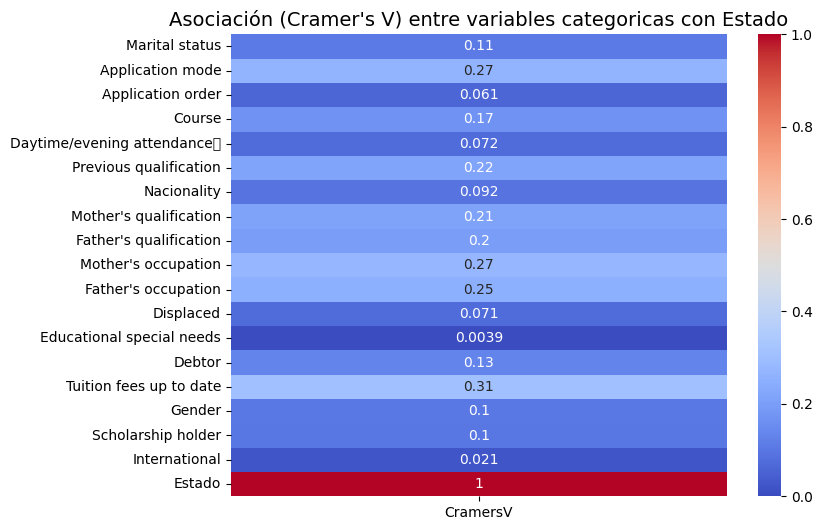

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# --- Calcular correlación con Estado ---
cramers_results = {}
for col in Cat_vars.columns:
    if col != 'Target':
        cramers_results[col] = cramers_v(Cat_vars['Estado'], Cat_vars[col])

# Convertir resultados a DataFrame
cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['CramersV'])

# --- Graficar heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Asociación (Cramer's V) entre variables categoricas con Estado", fontsize=14)
plt.show()


El análisis de asociación mediante la V de Cramer destaca que los factores de índole económica y académica son los más relevantes. La variable "Tuition fees up to date" (Matrículas al día) presenta la asociación más fuerte con el "Estado" (V=0.31), seguida por "Mother's occupation" (Trabajo de la madre) (V=0.27) y "Application mode" (Modo de aplicación) (V=0.27). En contraste, variables como "Educational special needs" (Necesidades educativas especiales) (V=0.0039) e "International" (Internacional) (V=0.021) muestran una asociación casi nula, sugiriendo una escasa relevancia predictiva.

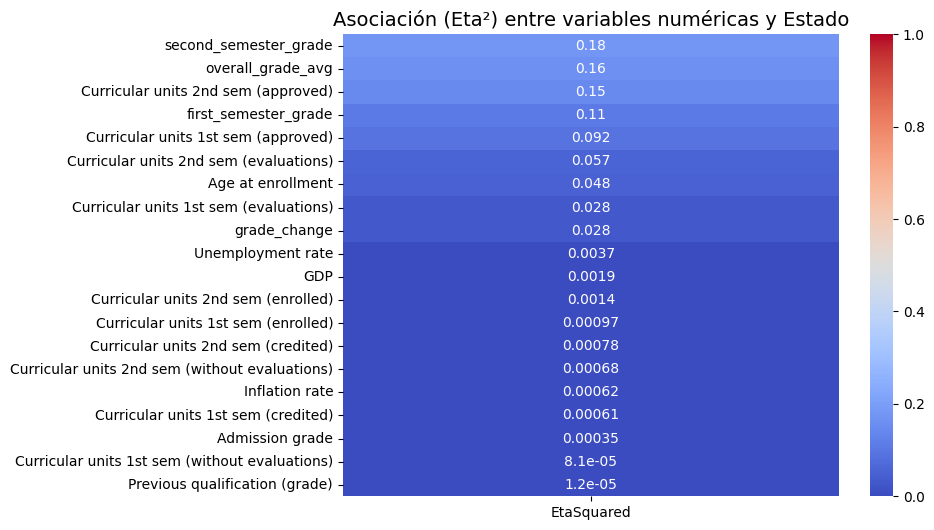

In [11]:
def eta_squared(x, y):
    # y = categórica, x = numérica
    data = pd.DataFrame({ 'x': x, 'y': y })
    model = smf.ols('x ~ C(y)', data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    eta_sq = anova_table['sum_sq']['C(y)'] / sum(anova_table['sum_sq'])
    return eta_sq

# Calcular eta² para todas las variables numéricas con respecto a Estado
eta_results = {}
for col in Num_vars.columns:
    if col != 'Estado':
        eta_results[col] = eta_squared(Num_vars[col], df['Estado'])

eta_df = pd.DataFrame.from_dict(eta_results, orient='index', columns=['EtaSquared'])
eta_df = eta_df.sort_values(by='EtaSquared', ascending=False)
plt.figure(figsize=(8,6))
sns.heatmap(eta_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Asociación (Eta²) entre variables numéricas y Estado", fontsize=14)
plt.show()

El análisis de asociación (Eta²) para las variables numéricas indica que el rendimiento académico del estudiante es el factor predictivo predominante para la variable "Estado". Las variables con mayor poder explicativo son las "unidades curriculares aprobadas del 2º semestre" (η²=0.39) y la "nota del 2º semestre" (η²=0.34). En contraste, los indicadores macroeconómicos como la "tasa de inflación" (η²=0.00079) y el "PIB" (η²=0.0022) tienen una asociación prácticamente nula, lo que demuestra que el desempeño individual del estudiante es mucho más relevante que el contexto económico general.

                         Association  EtaSquared
Tuition fees up to date     0.307319         NaN
Mother's occupation         0.273948         NaN
Application mode            0.265087         NaN
Father's occupation         0.251452         NaN
Previous qualification      0.216509         NaN
Mother's qualification      0.213492         NaN
Father's qualification      0.198647         NaN
Course                      0.168957         NaN
Debtor                      0.130931         NaN
Marital status              0.108017         NaN


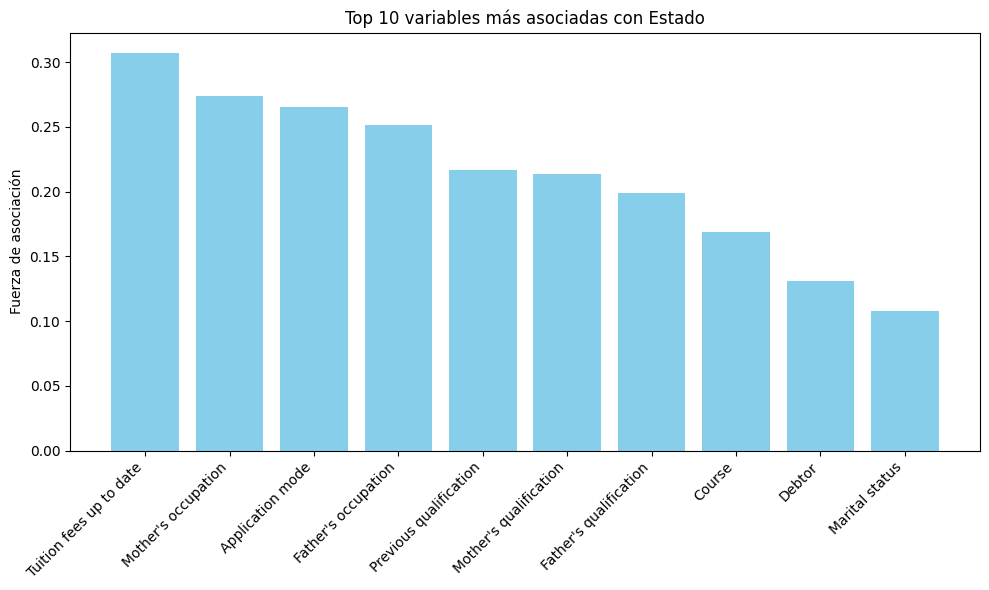

In [12]:
cramers_df = cramers_df.rename(columns={'CramersV': 'Association'})
eta_df = eta_df.rename(columns={'Eta2': 'Association'})

# Combinar ambas en una sola
combined_df = pd.concat([cramers_df, eta_df])
combined_df = combined_df.drop(index='Estado', errors='ignore')


# Ordenar por la fuerza de asociación
top_10 = combined_df.sort_values(by='Association', ascending=False).head(10)
print(top_10)
# Graficar

plt.figure(figsize=(10, 6))
plt.bar(top_10.index, top_10['Association'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fuerza de asociación')
plt.title('Top 10 variables más asociadas con Estado')
plt.tight_layout()
plt.show()

El análisis de correlación revela que el estado de la matrícula ("Tuition fees up to date") es la variable con la asociación más fuerte con el estado del estudiante, mostrando un coeficiente de aproximadamente 0.43. A esta le sigue la condición de becado ("Scholarship holder") con una fuerza de asociación de alrededor de 0.3. Otras variables relevantes, aunque con menor impacto, incluyen el curso, la condición de deudor, el género y el modo de aplicación. Es notable que las ocupaciones y cualificaciones de los padres se encuentran entre las variables con menor grado de asociación dentro de este grupo de las 10 principales. Estos hallazgos sugieren que los factores económicos y académicos inmediatos del estudiante son los predictores más significativos de su estado.

In [13]:
def VIF_calculation(X):
    VIF = pd.DataFrame()
    VIF["variable"] = X.columns
    VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    VIF = VIF.sort_values('VIF', ascending=False).reset_index(drop = True)
    return(VIF)
def delete_multicollinearity(df, target_name, VIF_threshold):
  X = df.drop(target_name, axis=1)
  VIF_mat = VIF_calculation(X)
  n_VIF = VIF_mat["VIF"][0]
  if (n_VIF <= VIF_threshold):
    print("There is no multicollinearity!")
  else:
    while (n_VIF > VIF_threshold):
      X = X.drop(VIF_mat["variable"][0], axis=1)
      VIF_mat = VIF_calculation(X)
      n_VIF = VIF_mat["VIF"][0]
  display(VIF_mat)
  return X
df_copy=df.copy()
df_copy = delete_multicollinearity(df_copy, "Estado", 10)

,variable,VIF
0,Curricular units 2nd sem (credited),9.113857
1,Curricular units 1st sem (credited),8.523909
2,first_semester_grade,7.956448
3,Curricular units 2nd sem (evaluations),7.326419
4,Daytime/evening attendance\t,6.768556
5,Father's occupation,5.965165
6,Mother's occupation,5.913001
7,Curricular units 2nd sem (approved),5.434982
8,Tuition fees up to date,4.836449
9,Father's qualification,4.344723


Aqui decidimos realizar una prueba de Factor de Inflación de la Varianza, o sus siglas en ingles  VIF para poder abordar la multicolinealidad, aunque para este tipo de modelos no es extrictamente necesario filtrar las variables predictoras dependiendo si son dependiente o independientes.

El análisis de correlación revela que el estado de la matrícula ("Tuition fees up to date") es la variable con la asociación más fuerte con el estado del estudiante, mostrando un coeficiente de aproximadamente 0.3. A esta le sigue la ocupación de la madre ("Mother's occupation") con una fuerza de asociación de alrededor de 0.27. Otras variables relevantes, aunque con menor impacto, incluyen el curso, la condición de deudor,el estado civil y el modo de aplicación. Estos hallazgos sugieren que los factores económicos y académicos inmediatos del estudiante son los predictores más significativos de su estado.

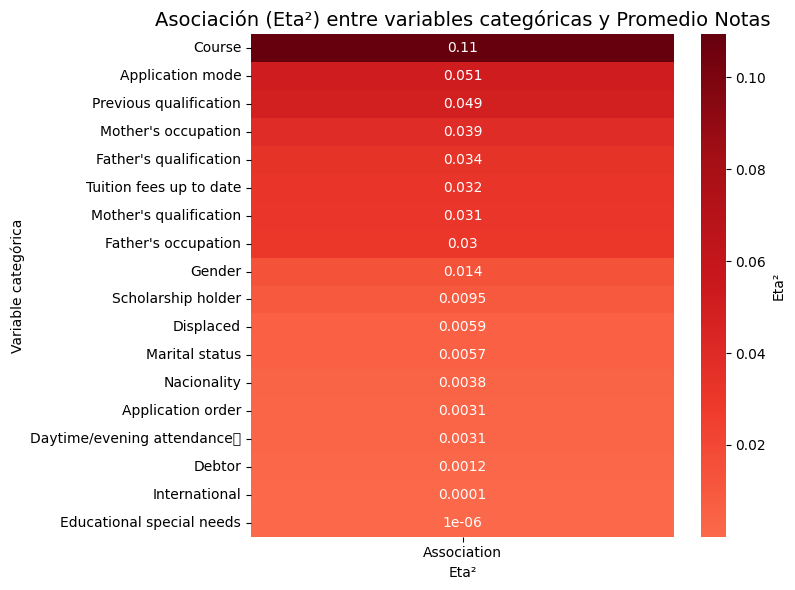

In [14]:
# ---------- 1. Eta² para categóricas vs Promedio Notas ----------
def eta_squared_num_cat(cat, num):
    groups = [num[cat == level] for level in cat.unique()]
    f_val, p_val = f_oneway(*groups)
    ss_between = sum(len(g) * (g.mean() - num.mean())**2 for g in groups)
    ss_total = sum((num - num.mean())**2)
    eta2 = ss_between / ss_total
    return eta2

eta_results = {}
for col in Cat_vars.columns:
    eta_results[col] = eta_squared_num_cat(Cat_vars[col], Num_vars['overall_grade_avg'])

eta_df = pd.DataFrame.from_dict(eta_results, orient='index', columns=['Association'])

# 🔹 Eliminar "Estado" y variables duplicadas con Num_vars
eta_df = eta_df.drop(index="Estado", errors="ignore")
eta_df = eta_df[~eta_df.index.isin(Num_vars.columns)]

# Ordenar
eta_df = eta_df.sort_values(by='Association', ascending=False)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(eta_df, annot=True, cmap='Reds', center=0, cbar_kws={'label': 'Eta²'})
plt.title("Asociación (Eta²) entre variables categóricas y Promedio Notas", fontsize=14)
plt.ylabel("Variable categórica")
plt.xlabel("Eta²")
plt.tight_layout()
plt.show()


El análisis muestra que la carrera elegida ("Course") es el factor más determinante en el promedio de las notas (η² = 0.11). El resto de variables, incluyendo el estado de la matrícula y factores socioeconómicos, tienen una influencia considerablemente menor, siendo en su mayoría mínima o casi nula.

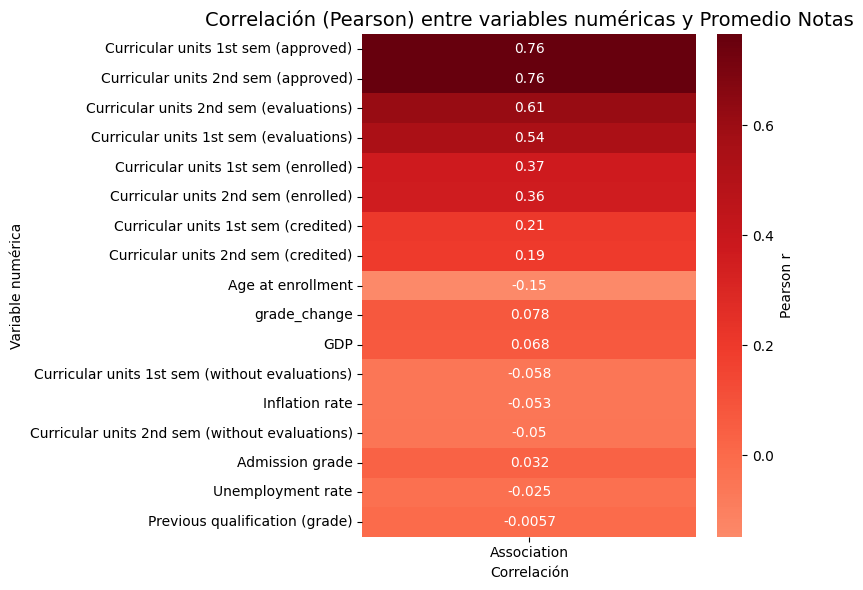

In [15]:
# ---------- 2. Pearson para numéricas vs Promedio Notas ----------
pearson_results = Num_vars.corr()['overall_grade_avg'].drop(['overall_grade_avg', 'first_semester_grade', 'second_semester_grade']).to_frame(name='Association')
pearson_results = pearson_results.reindex(pearson_results['Association'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(8,6))
sns.heatmap(pearson_results, annot=True, cmap='Reds', center=0, cbar_kws={'label': 'Pearson r'})
plt.title("Correlación (Pearson) entre variables numéricas y Promedio Notas", fontsize=14)
plt.ylabel("Variable numérica")
plt.xlabel("Correlación")
plt.tight_layout()
plt.show()

El análisis de correlación revela que los predictores más potentes del promedio de las notas son las métricas de desempeño durante el curso, no los factores de ingreso ni los socioeconómicos. Las variables Unidades curriculares (aprobadas) (r=0.76) y (evaluaciones) (r≈0.6) dominan claramente, mientras que la Nota de admisión y factores como el GDP son prácticamente irrelevantes.

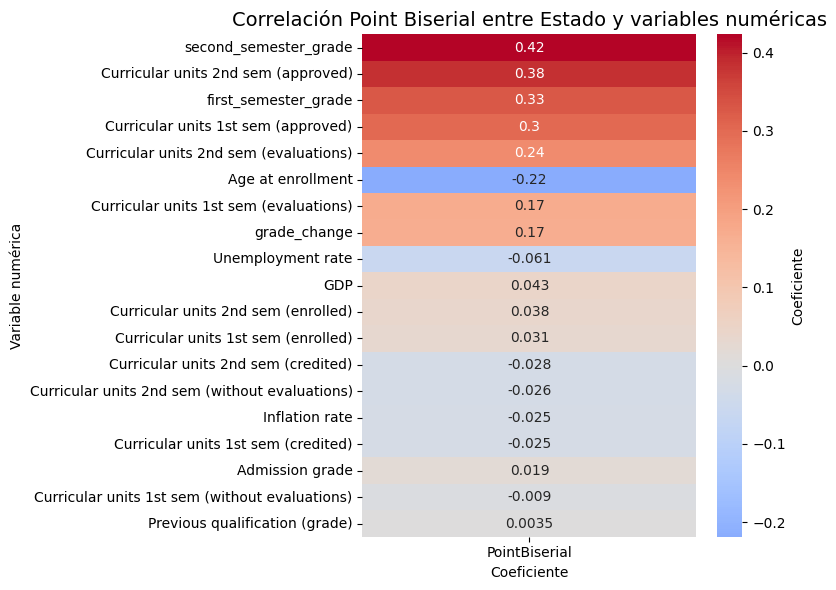

,PointBiserial,p-value
second_semester_grade,0.423535,3.969968e-97
Curricular units 2nd sem (approved),0.384410,6.370730e-79
first_semester_grade,0.330043,1.939041e-57
Curricular units 1st sem (approved),0.302821,3.364261e-48
Curricular units 2nd sem (evaluations),0.238943,3.956526e-30


In [16]:
# The Point Biserial Coefficient of Correlation

from scipy.stats import pointbiserialr

# Correlación entre Estado y todas las variables numéricas, excluyendo 'Estado' y 'overall_grade_avg'
pb_results = {}
for col in Num_vars.columns:
    if col not in ['Estado', 'overall_grade_avg']:
        coef, pval = pointbiserialr(df['Estado'], Num_vars[col])
        pb_results[col] = {'PointBiserial': coef, 'p-value': pval}

pb_df = pd.DataFrame(pb_results).T
pb_df = pb_df.sort_values(by='PointBiserial', key=lambda x: abs(x), ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(pb_df[['PointBiserial']], annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Coeficiente'})
plt.title("Correlación Point Biserial entre Estado y variables numéricas", fontsize=14)
plt.ylabel("Variable numérica")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

# Mostrar las 5 más correlacionadas
pb_df.head(5)

Al igual que con el Eta, se confirma que el rendimiento académico semestral es el predictor más fuerte del resultado final del estudiante, superando a cualquier otro tipo de dato.

# **EDA**

Por efectos de tiempo y practicos escogeremos las 5 variables con mayor asociación a las variables 'Estado' y 'first_semester_grade', para la realización del EDA es decir:
- Estado: 'Tuitions to feed up', 'Scholarship holder, 'Course', 'Debtor', 'Gender'.
- first_semester_grade: 'second_semester_grade','Curricular units 1st sem(approved)', 'Curricular units 2nd sem(approved)', 'Curricular units 1st sem (Evaluations)', 'Curricular units 2nd sem (Enrolled).

## Variables respuesta

Para el proyecto nuestras variables respuesta o "Target" serán __Estado__ y __Las notas del primer semestre__

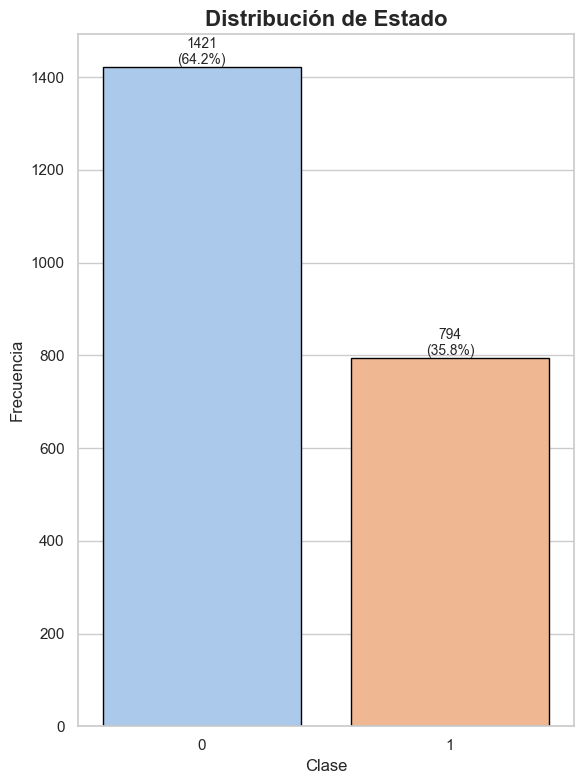

In [17]:
sns.set(style="whitegrid", palette="pastel", font_scale=1)

plt.figure(figsize=(6, 8))
ax = sns.countplot(data=df, x='Estado', hue='Estado', legend=False,
                   palette='pastel', edgecolor='black')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}\n({height/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10)
plt.title('Distribución de Estado', fontsize=16, weight='bold')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Con este grafico podemos apreciar la distribución de clases de nuestra variable __Estado__, la cual presenta un gran desbalance.
Mientras que la clase **Enrolled** logra apenas un 35% de los datos, con 794 estudiantes, la categoria **Dropout**  tiene más de 1400 registros cubriendo casi el 65% de los datos.

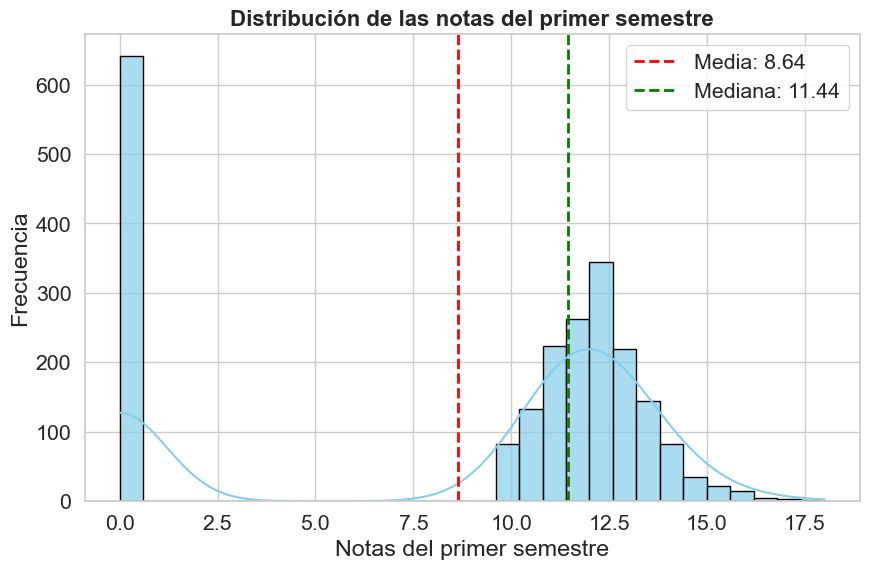

In [18]:
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(9, 6))

# histograma + densidad
ax = sns.histplot(data=df, x='first_semester_grade', bins=30, kde=True,
                  color='skyblue', edgecolor='black', alpha=0.7)
# título y ejes
plt.title(f'Distribución de las notas del primer semestre', fontsize=16, weight='bold')
plt.xlabel('Notas del primer semestre')
plt.ylabel('Frecuencia')
# estadísticas clave en el gráfico
mean_val = df['first_semester_grade'].mean()
median_val = df['first_semester_grade'].median()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

El histograma revela una distribución marcadamente bimodal. Se observa una concentración anómala de notas en cero. El resto de las calificaciones se agrupa de forma casi normal, con una mediana de 11.44, que es una medida más representativa del rendimiento del estudiante típico que la media (8.64), la cual se ve fuertemente sesgada a la baja por los valores nulos.

## **Variables asociadas con el Estado**

### **Matrículas actualizadas**

'Tuition fees up to date'

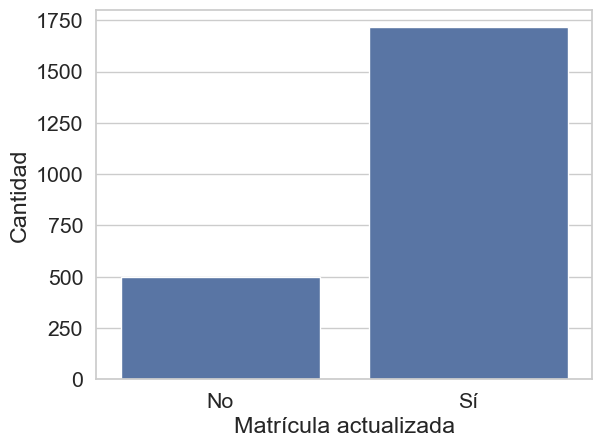

In [19]:
sns.countplot(x = 'Tuition fees up to date', data = df)
plt.xlabel('Matrícula actualizada')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No', 'Sí'])  # Cambia 0 y 1 por No y Sí
plt.show()

El gráfico ilustra un fuerte desbalance en la variable "Matrícula actualizada". Se observa que una abrumadora mayoría de los estudiantes (cerca de 2,000) sí cuenta con una matrícula vigente, mientras que una pequeña fracción (alrededor de 500) no

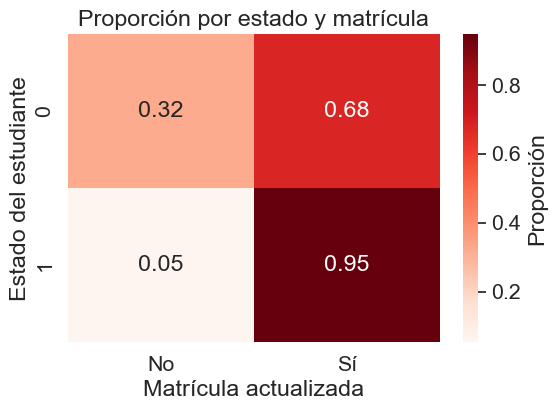

In [20]:
contingencia = pd.crosstab(df['Estado'], df['Tuition fees up to date'], normalize='index')
plt.figure(figsize=(6, 4))
sns.heatmap(contingencia, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Proporción'})
plt.xlabel('Matrícula actualizada')
plt.ylabel('Estado del estudiante')
plt.title('Proporción por estado y matrícula')
plt.xticks([0.5, 1.5], ['No', 'Sí'], ha='center', rotation=0)
plt.show()


Se revela una fuerte relación entre el estado del estudiante y si su matrícula está actualizada. La falta de matrícula ("No") es un indicador clave de deserción: mientras que es una condición rara en estudiantes inscritos (5%), representa al 32% del grupo de desertores ("Dropout").

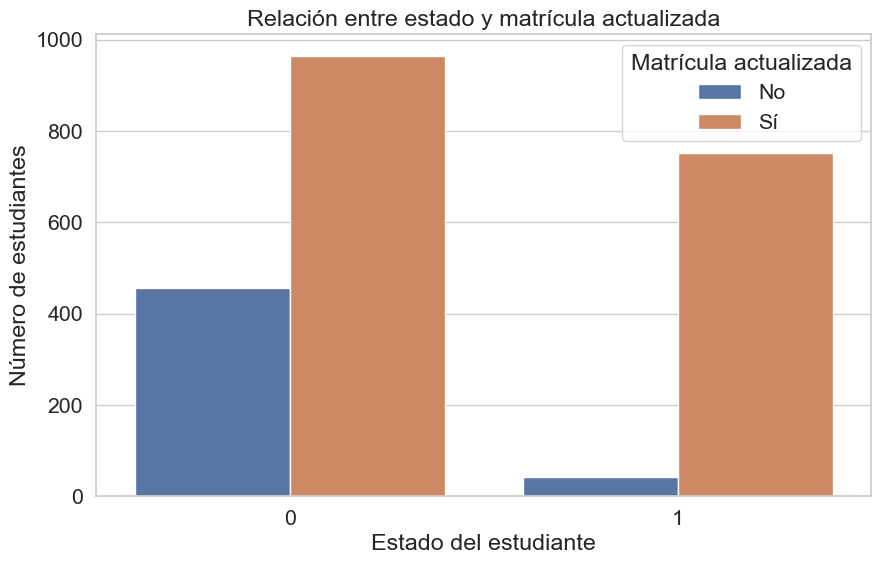

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Estado', hue='Tuition fees up to date', data=df)
plt.xlabel('Estado del estudiante')
plt.ylabel('Número de estudiantes')
plt.title('Relación entre estado y matrícula actualizada')
plt.legend(title='Matrícula actualizada', labels=['No', 'Sí'])
plt.show()

Se observa de manera contundente que el grupo de desertores ("Dropout") aglutina la gran mayoría de los estudiantes con matrícula no actualizada. Para los estudiantes actualmente inscritos, no tener la matrícula al día es una situación prácticamente inexistente, lo que subraya la fuerte capacidad de esta variable para señalar un riesgo de abandono.

### **Becario**
'Scholarship holder'

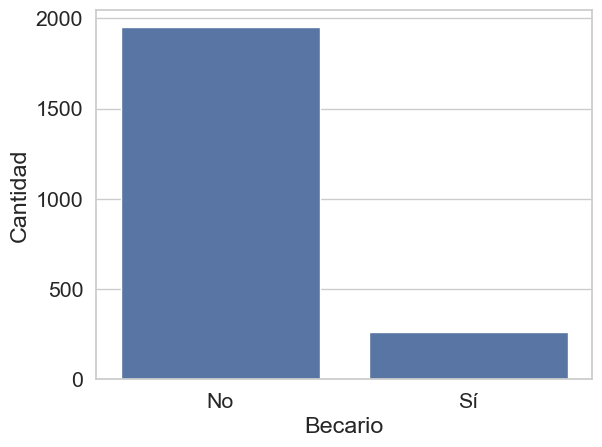

In [22]:
sns.countplot(x = 'Scholarship holder', data = df)
plt.xlabel('Becario')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No', 'Sí'])  
plt.show()

Con casi  2,000 estudiantes sin beca frente a poco más de 300 que sí la tienen. Esta distribución indica que, si bien la ayuda económica está presente, no es la condición predominante en esta población estudiantil.

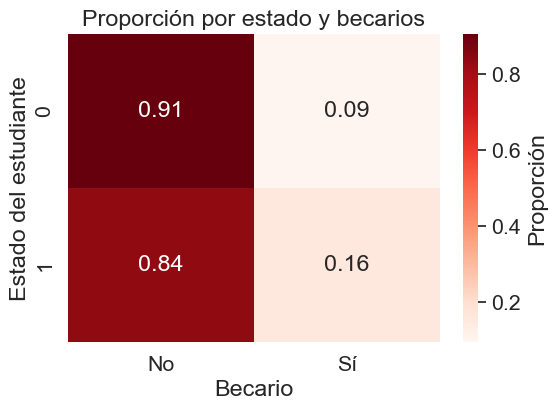

In [23]:
contingencia = pd.crosstab(df['Estado'], df['Scholarship holder'], normalize='index')
plt.figure(figsize=(6, 4))
sns.heatmap(contingencia, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Proporción'})
plt.xlabel('Becario')
plt.ylabel('Estado del estudiante')
plt.title('Proporción por estado y becarios')
plt.xticks([0.5, 1.5], ['No', 'Sí'], ha='center', rotation=0)
plt.show()

Notablemente, la proporción de becarios disminuye para los estudiantes que desertan, donde solo el 9% contaba con beca. Esto sugiere que la condición de becario está positivamente asociada con la persistencia y la culminación de los estudios.

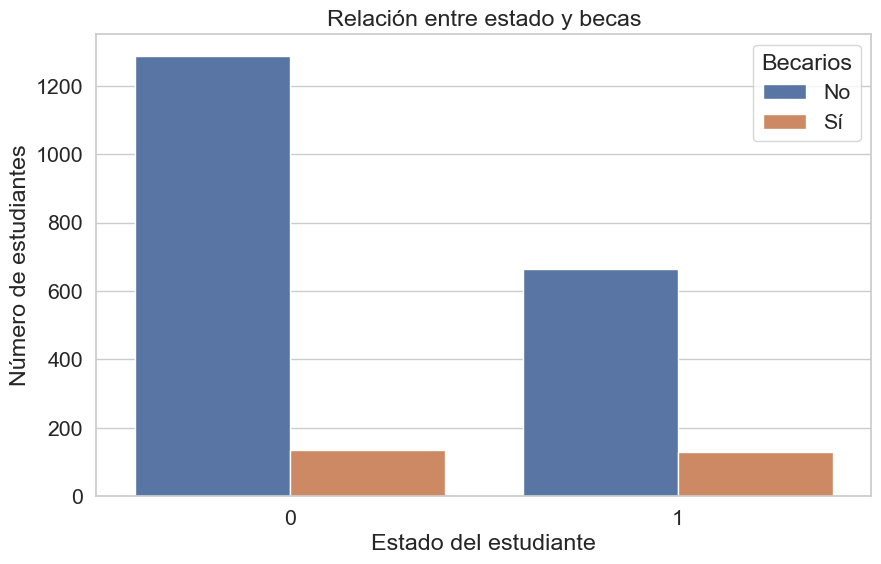

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Estado', hue='Scholarship holder', data=df)
plt.xlabel('Estado del estudiante')
plt.ylabel('Número de estudiantes')
plt.title('Relación entre estado y becas')
plt.legend(title='Becarios', labels=['No', 'Sí'])
plt.show()

Se confirma el patrón observado anteriormente: el número absoluto de estudiantes no becados es alto, pero la diferencia es abrumadora en el grupo de desertores ("Dropout"). Lo que refuerza la fuerte asociación positiva entre tener una beca y la probabilidad de completar los estudios exitosamente.

### **Curso**
'Course'

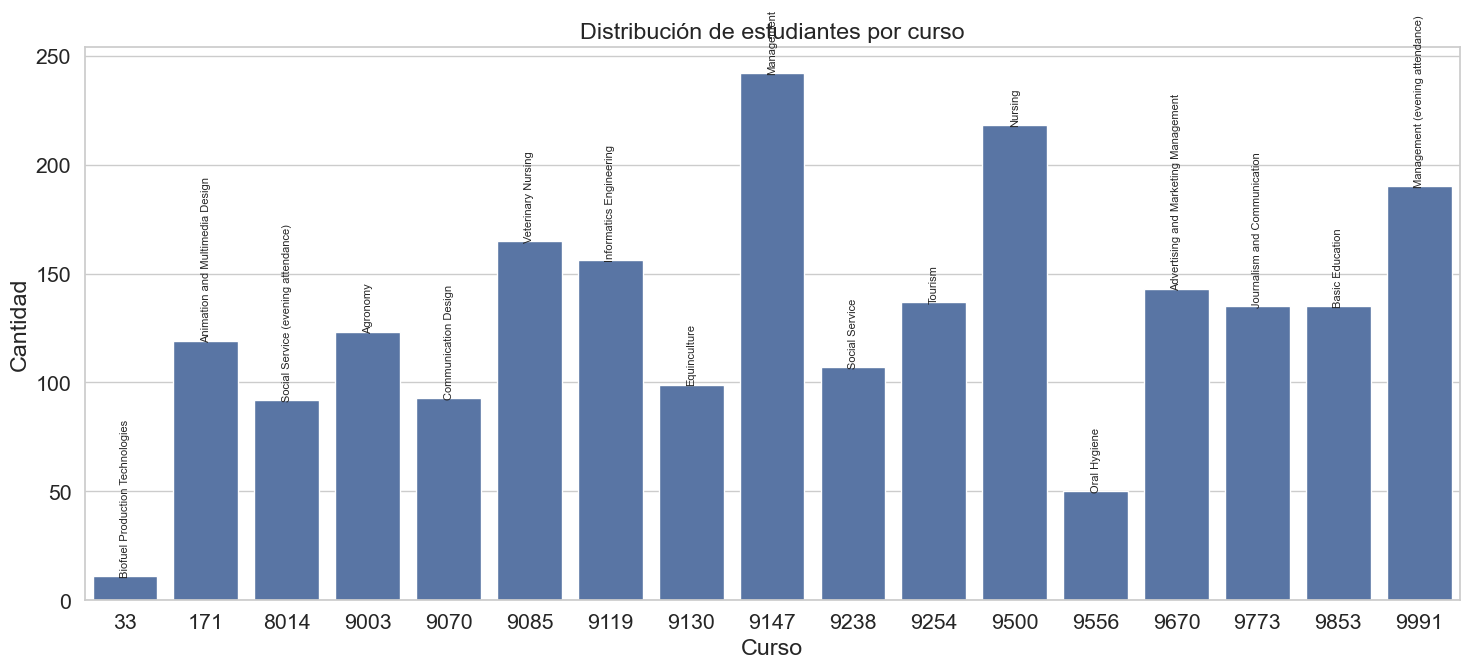

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Diccionario de código a nombre
course_names = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
}

plt.figure(figsize=(15, 7))
ax = sns.countplot(x='Course', data=df)

plt.xlabel('Curso')
plt.ylabel('Cantidad')
plt.title('Distribución de estudiantes por curso')

# Colocar nombre encima de cada barra
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    code = int(p.get_x() + 0.5)  # No usar así, mejor sacar directamente el valor x-tick
    # Mejor: sacamos el valor del tick (código) desde los xticks y usamos el índice
# Mejor método:
    
# Obtener las posiciones y etiquetas actuales de las barras (códigos)
ticks = ax.get_xticks()
labels = [int(t.get_text()) for t in ax.get_xticklabels()]

# Como en countplot el orden de barras es el orden de aparición, podemos usar:
for i, p in enumerate(ax.patches):
    height = p.get_height()
    code = int(ax.get_xticklabels()[i].get_text())
    ax.text(p.get_x() + p.get_width()/2, height + 0.5, course_names.get(code, str(code)), 
            ha='center', rotation=90, fontsize=8)

plt.tight_layout()
plt.show()



El gráfico revela una marcada disparidad en la distribución de estudiantess entre los distintos programas académicos. El curso de "Management (código 9147) destaca de forma abrumadora, concentrando la mayor cantidad de estudiantes, llegando a casi 250. Otros programas como "Nursing" (9500), "Management (evening attendance)" (9999) y Enfermería Veterinaria (9085) también presentan un número significativo de estudiante, pero en una escala mucho menor.

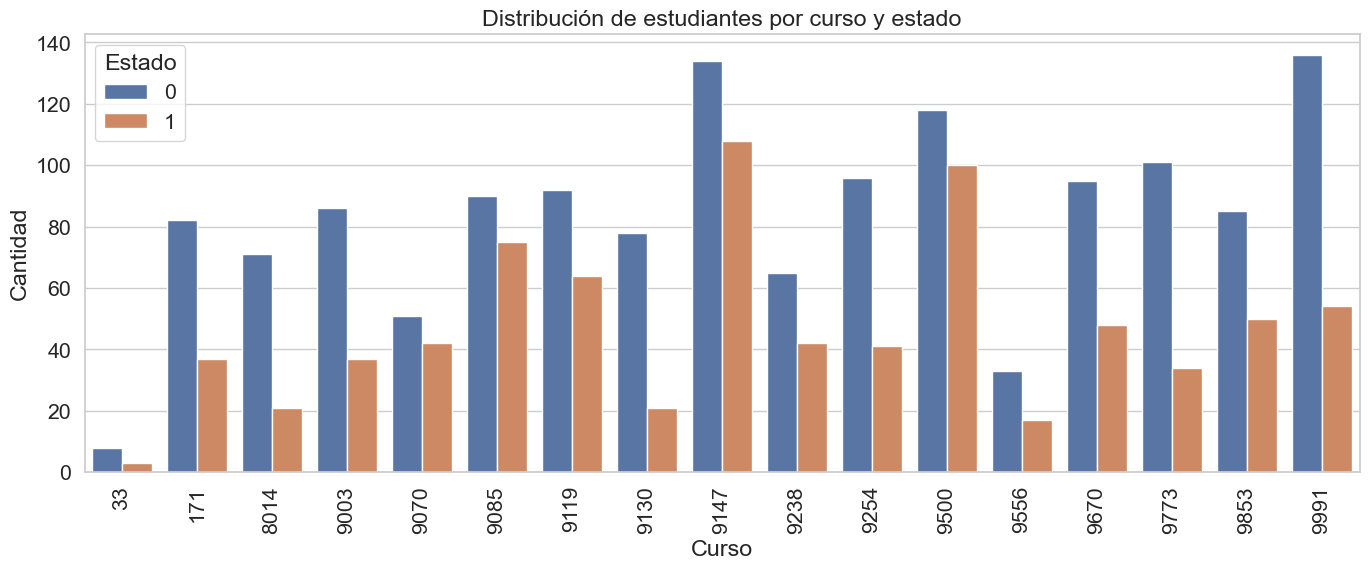

In [26]:
plt.figure(figsize=(14,6))
sns.countplot(x='Course', hue='Estado', data=df)
plt.xticks(rotation=90)
plt.xlabel('Curso')
plt.ylabel('Cantidad')
plt.title('Distribución de estudiantes por curso y estado')
plt.legend(title='Estado')
plt.tight_layout()
plt.show()


 La carrera de Gestión (9147) cuenta con la mayor población estudiantil, con un gran numero tanto de desertores como de matriculados.
 Es importante resaltar que en todos los cursos el numero de desertores es mayor que el numero de matriculados, pero hay ciertos cursos como el de Gestion (por la noches) (9991) y Comunicación y periodismo (9773) en los que existe un diferencia abismal entre estas las dos categorias

### **Deudor**
'Debtor'

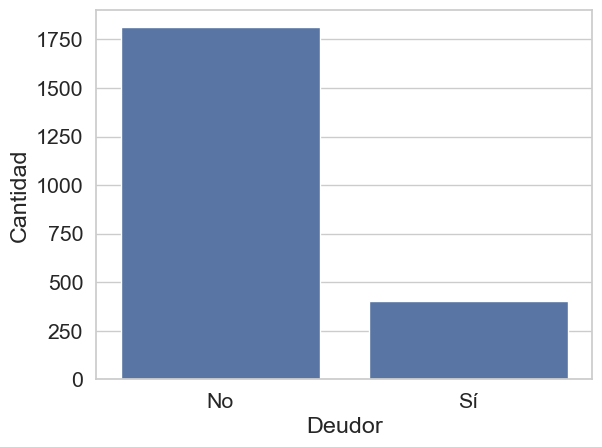

In [27]:
sns.countplot(x = 'Debtor', data = df)
plt.xlabel('Deudor')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No', 'Sí'])  # Cambia 0 y 1 por No y Sí
plt.show()

Se observa un fuerte desbalance, con casi 1,750 estudiantes que no son deudores frente a un grupo considerablemente menor, de alrededor de 400, que sí lo son. Este desequilibrio define a la condición de "Deudor" como una clase minoritaria dentro del conjunto de datos.

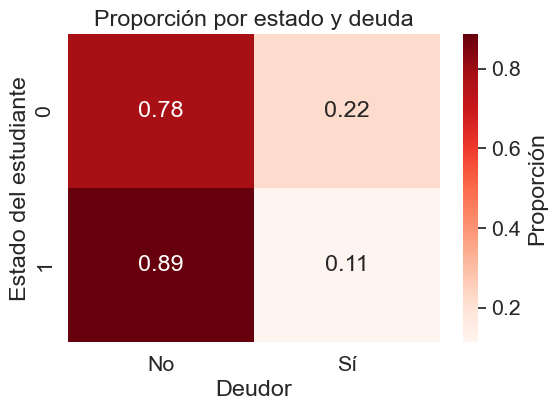

In [28]:
contingencia = pd.crosstab(df['Estado'], df['Debtor'], normalize='index')
plt.figure(figsize=(6, 4))
sns.heatmap(contingencia, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Proporción'})
plt.xlabel('Deudor')
plt.ylabel('Estado del estudiante')
plt.title('Proporción por estado y deuda')
plt.xticks([0.5, 1.5], ['No', 'Sí'], ha='center', rotation=0)
plt.show()


La condición de deudor es notablemente más frecuente entre los estudiantes que han desertado ("Dropout"), alcanzando al 22% de este grupo. Esta proporción disminuye para los estudiantes actualmente inscritos (11%). Estos datos sugieren que las dificultades económicas, manifestadas como deuda, son un factor de riesgo  asociado a la deserción estudiantil.

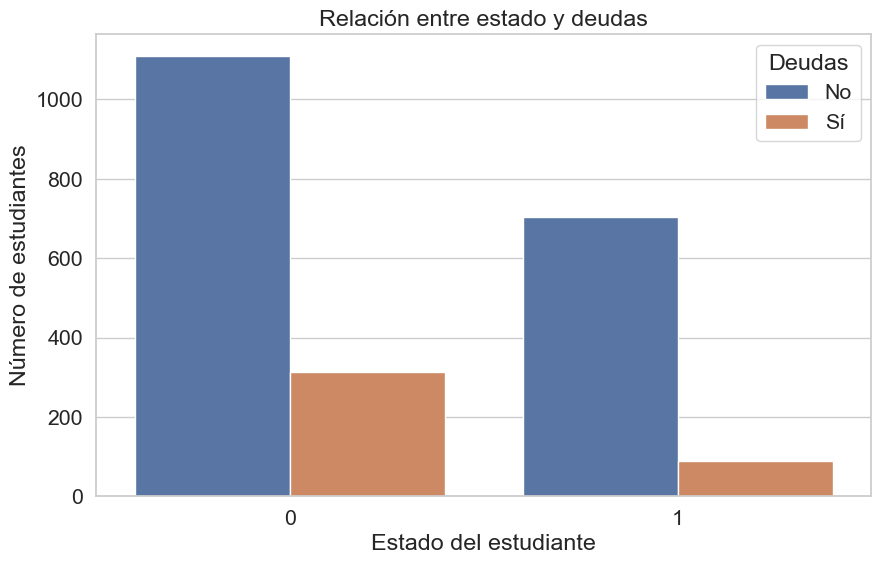

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Estado', hue='Debtor', data=df)
plt.xlabel('Estado del estudiante')
plt.ylabel('Número de estudiantes')
plt.title('Relación entre estado y deudas')
plt.legend(title='Deudas', labels=['No', 'Sí'])
plt.show()

El hallazgo más significativo es que el grupo de desertores ("Dropout") concentra, por un amplio margen, el mayor número absoluto de estudiantes con deudas. Esta visualización subraya que la carga de la deuda es una característica predominante en la población que abandona sus estudios, consolidando su valor como un potente indicador de riesgo.

### **Género**
'Gender'

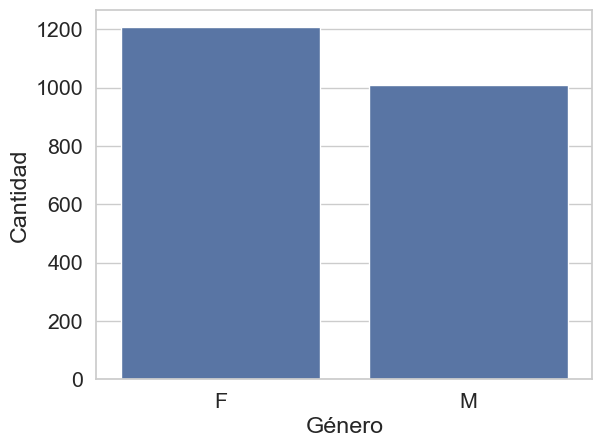

In [30]:
sns.countplot(x = 'Gender', data = df)
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['F', 'M'])  # Cambia 0 y 1 por No y Sí
plt.show()

 Existe una predominancia significativa de estudiantes de género femenino (cerca de 1,200) sobre el masculino (aproximadamente 1,000).

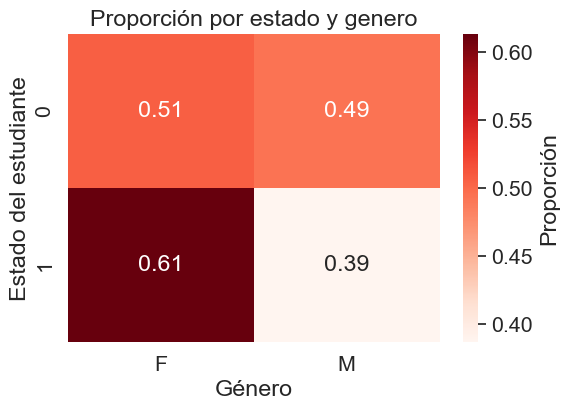

In [31]:
contingencia = pd.crosstab(df['Estado'], df['Gender'], normalize='index')
plt.figure(figsize=(6, 4))
sns.heatmap(contingencia, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Proporción'})
plt.xlabel('Género')
plt.ylabel('Estado del estudiante')
plt.title('Proporción por estado y genero')
plt.xticks([0.5, 1.5], ['F', 'M'], ha='center', rotation=0)
plt.show()


 La distribución de género entre los desertores ("Dropout") es prácticamente equitativa, es en el estado de matriculado donde se puede ver una diferencia, pero esto solo confirma que hay una mayor poblacion femenina en la universidad

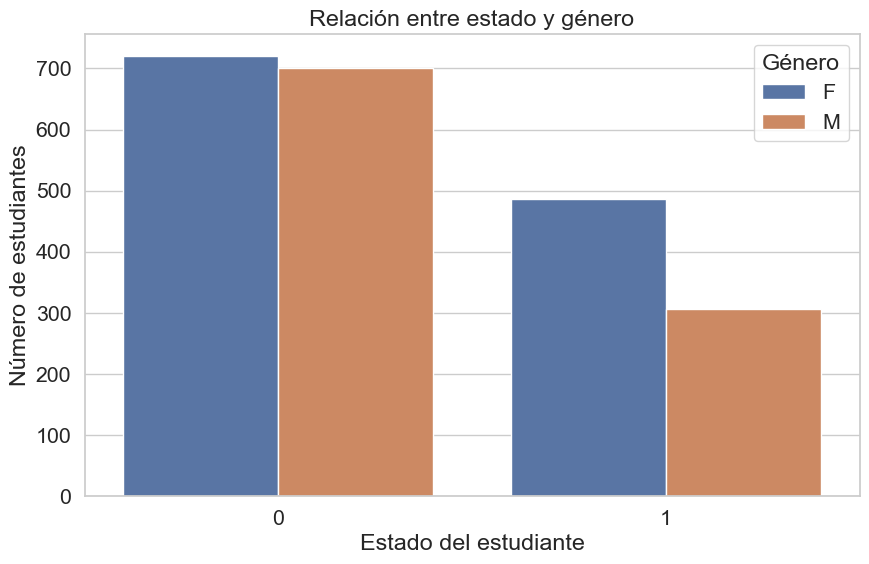

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Estado', hue='Gender', data=df)
plt.xlabel('Estado del estudiante')
plt.ylabel('Número de estudiantes')
plt.title('Relación entre estado y género')
plt.legend(title='Género', labels=['F', 'M'])
plt.show()

El número de mujeres que se gradúan (más de 1600) es casi el triple que el de los hombres, lo que demuestra un rendimiento y una tasa de finalización de estudios abrumadoramente superiores para el género femenino.
De manera interesante, el número de desertores es prácticamente el mismo para ambos géneros, a pesar de que hay muchas más mujeres en la población estudiantil total. Esto implica que, en términos relativos, la tasa de deserción es considerablemente mayor para los estudiantes masculinos.
Mientras que el abandono afecta a ambos géneros en números absolutos similares, el éxito académico, medido por la graduación, está fuertemente inclinado hacia las estudiantes femeninas.

## **Variables asociadas con las notas del primer semestre**

### Unidades curriculares 2do semestre (grado)
'Curricular units 2nd sem (grade)'

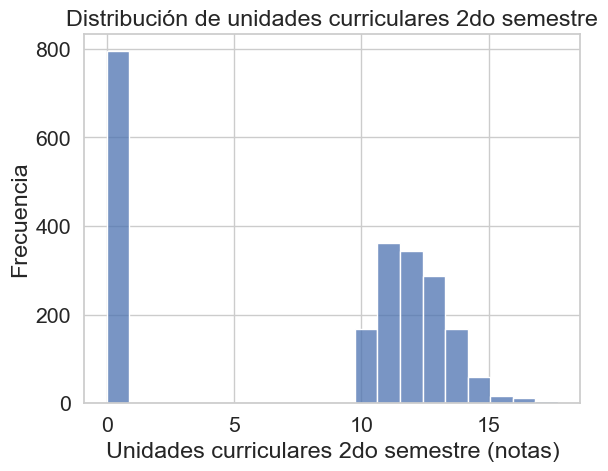

In [33]:
sns.histplot(df['second_semester_grade'], bins=20)
plt.xlabel('Unidades curriculares 2do semestre (notas)')
plt.ylabel('Frecuencia')
plt.title('Distribución de unidades curriculares 2do semestre')
plt.show()


Un pico anómalo en cero identifica a una subpoblación inactiva, muy probablemente desertores, mientras que la distribución normal posterior representa a los estudiantes activos con una carga académica estándar.

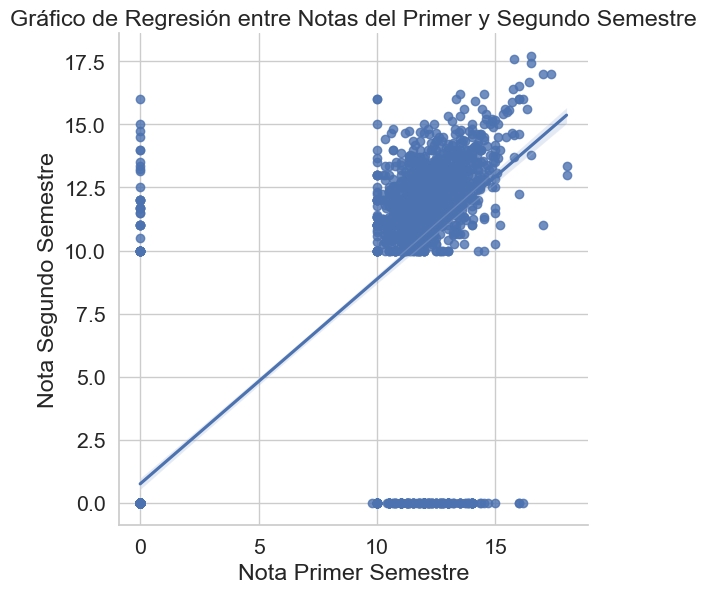

In [34]:
sns.lmplot(data=df, x='first_semester_grade', y='second_semester_grade', height=6)
plt.title('Gráfico de Regresión entre Notas del Primer y Segundo Semestre')
plt.xlabel('Nota Primer Semestre')
plt.ylabel('Nota Segundo Semestre')
plt.grid(True)
plt.show()

El gráfico muestra correlación positiva para el grupo principal de estudiantes, pero la gran cantidad de puntos en el valor 'cero' de ambos ejes distorsiona fuertemente la línea de regresión. Esto sugiere que el cero no es una calificación real, sino un valor que representa datos ausentes o abandonos

### Unidades curriculares 1er semestre (aprobadas)
'Curricular units 1st sem(approved)'

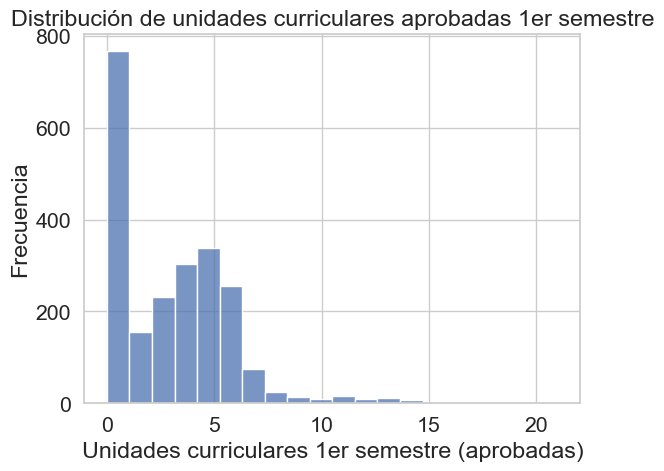

In [35]:
sns.histplot(df['Curricular units 1st sem (approved)'], bins=20)
plt.xlabel('Unidades curriculares 1er semestre (aprobadas)')
plt.ylabel('Frecuencia')
plt.title('Distribución de unidades curriculares aprobadas 1er semestre')
plt.show()


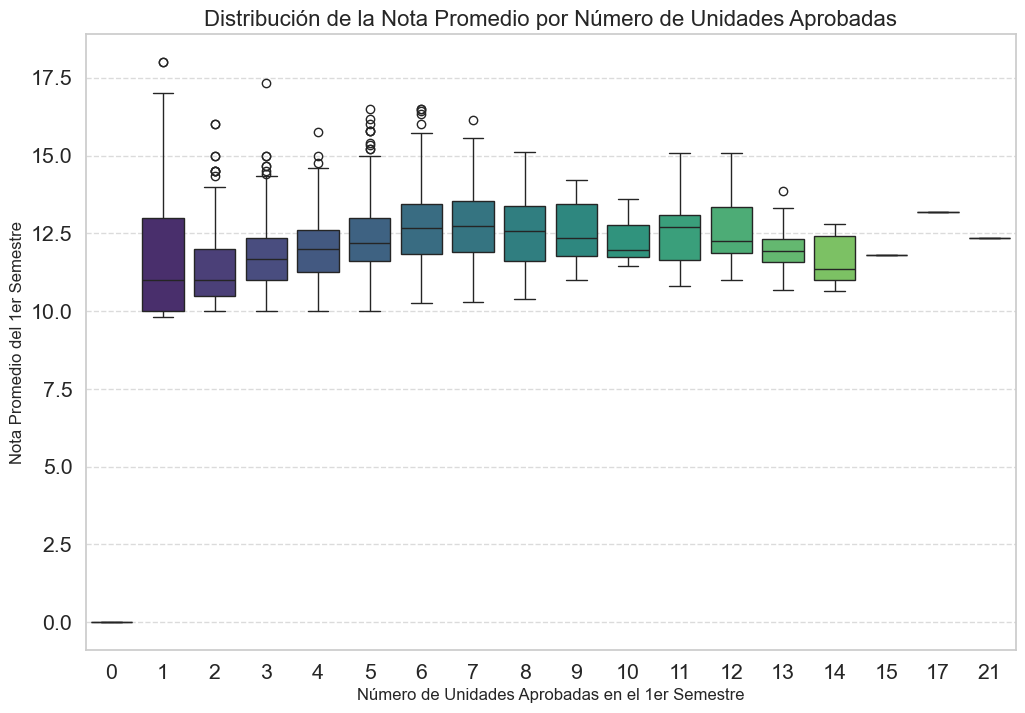

In [36]:
plt.figure(figsize=(12, 8))

# INVERTIMOS LAS VARIABLES EN LOS EJES X e Y
sns.boxplot(
    data=df,
    x='Curricular units 1st sem (approved)', # Variable discreta como categoría
    y='first_semester_grade',                # Variable continua para la distribución
    palette='viridis'
)

plt.title('Distribución de la Nota Promedio por Número de Unidades Aprobadas', fontsize=16)
plt.xlabel('Número de Unidades Aprobadas en el 1er Semestre', fontsize=12)
plt.ylabel('Nota Promedio del 1er Semestre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

A medida que los estudiantes aprueban más unidades, su nota promedio tiende a ser más alta y consistente. Además, se observa una mayor dispersión de notas en quienes aprueban pocas materias, mientras que el rendimiento es más homogéneo y elevado en aquellos que superan una mayor cantidad de unidades.

### Unidades curriculares 2do semestre (aprobadas)
'Curricular units 2nd sem (approved)'

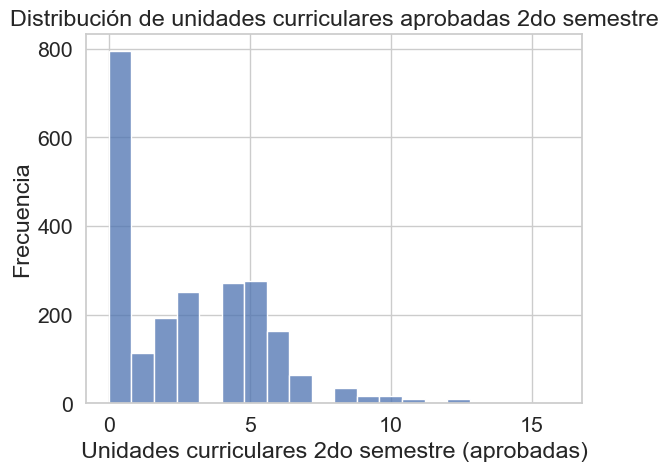

In [37]:
sns.histplot(df['Curricular units 2nd sem (approved)'], bins=20)
plt.xlabel('Unidades curriculares 2do semestre (aprobadas)')
plt.ylabel('Frecuencia')
plt.title('Distribución de unidades curriculares aprobadas 2do semestre')
plt.show()

El histograma revela una distribución bimodal de unidades curriculares aprobadas. Un gran número de estudiantes no aprobó ninguna unidad (valor 0, probable dropout). Un segundo pico significativo de aprobación se concentra entre 6  unidades. Muy pocos estudiantes aprueban más de 8 unidades, lo que sugiere un límite práctico en la carga académica exitosa.

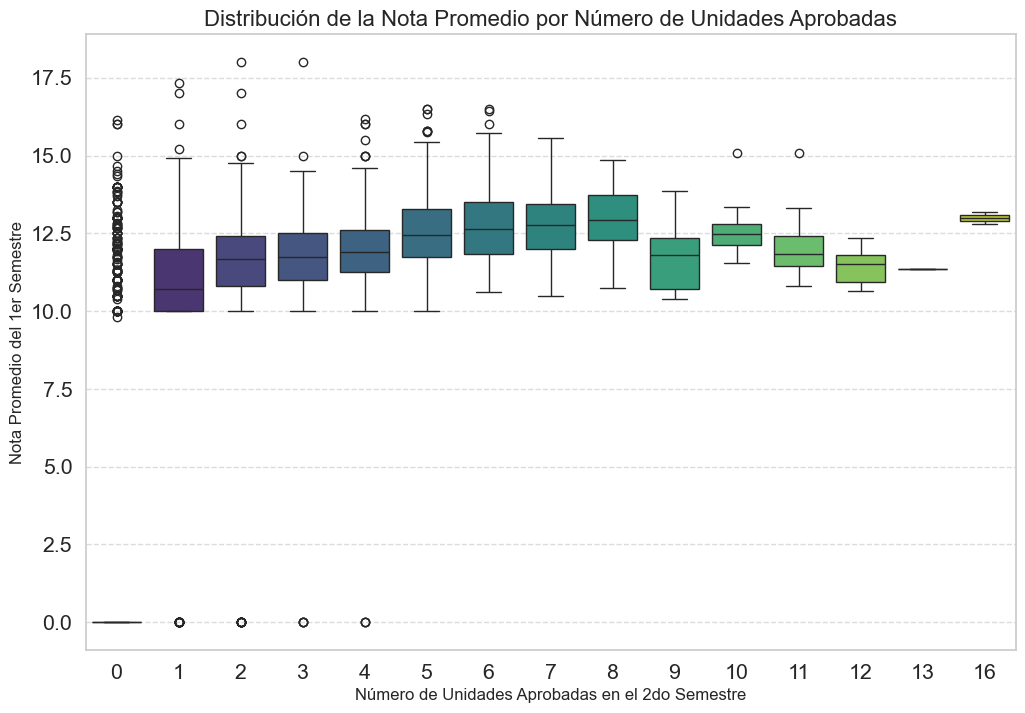

In [38]:
plt.figure(figsize=(12, 8))

# INVERTIMOS LAS VARIABLES EN LOS EJES X e Y
sns.boxplot(
    data=df,
    x='Curricular units 2nd sem (approved)', # Variable discreta como categoría
    y='first_semester_grade',                # Variable continua para la distribución
    palette='viridis'
)

plt.title('Distribución de la Nota Promedio por Número de Unidades Aprobadas', fontsize=16)
plt.xlabel('Número de Unidades Aprobadas en el 2do Semestre', fontsize=12)
plt.ylabel('Nota Promedio del 1er Semestre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Se observa una clara tendencia ascendente: a mayor número de unidades aprobadas en el segundo semestre, más alta y consistente fue la nota promedio del primero. El grupo que no aprueba ninguna materia es el más variado, incluyendo tanto a estudiantes con buen rendimiento previo (posibles abandonos) como a aquellos con notas bajas.

### Unidades curriculares 1er semestre (Evaluaciones)
 'Curricular units 1st sem (Evaluations)'

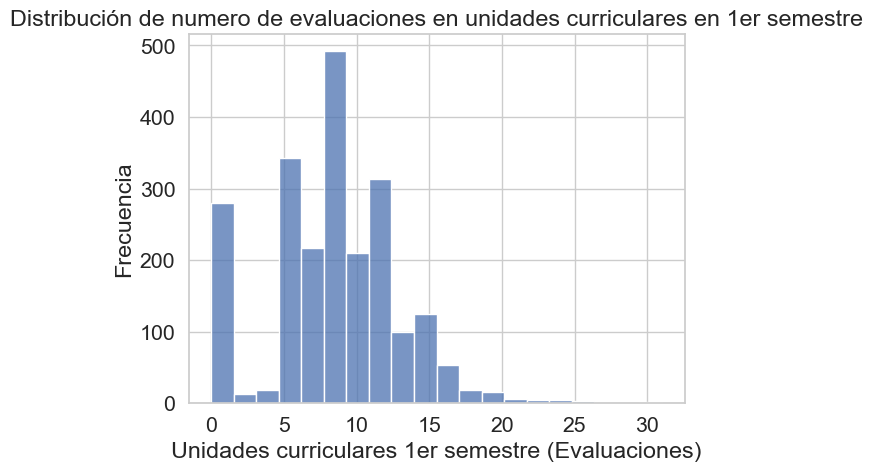

In [39]:
sns.histplot(df['Curricular units 1st sem (evaluations)'], bins=20)
plt.xlabel('Unidades curriculares 1er semestre (Evaluaciones)')
plt.ylabel('Frecuencia')
plt.title('Distribución de numero de evaluaciones en unidades curriculares en 1er semestre')
plt.show()

El histograma muestra que el número de evaluaciones por estudiante está concentrado principalmente entre 6 y 14, con la frecuencia más alta alrededor de 8-9 evaluaciones

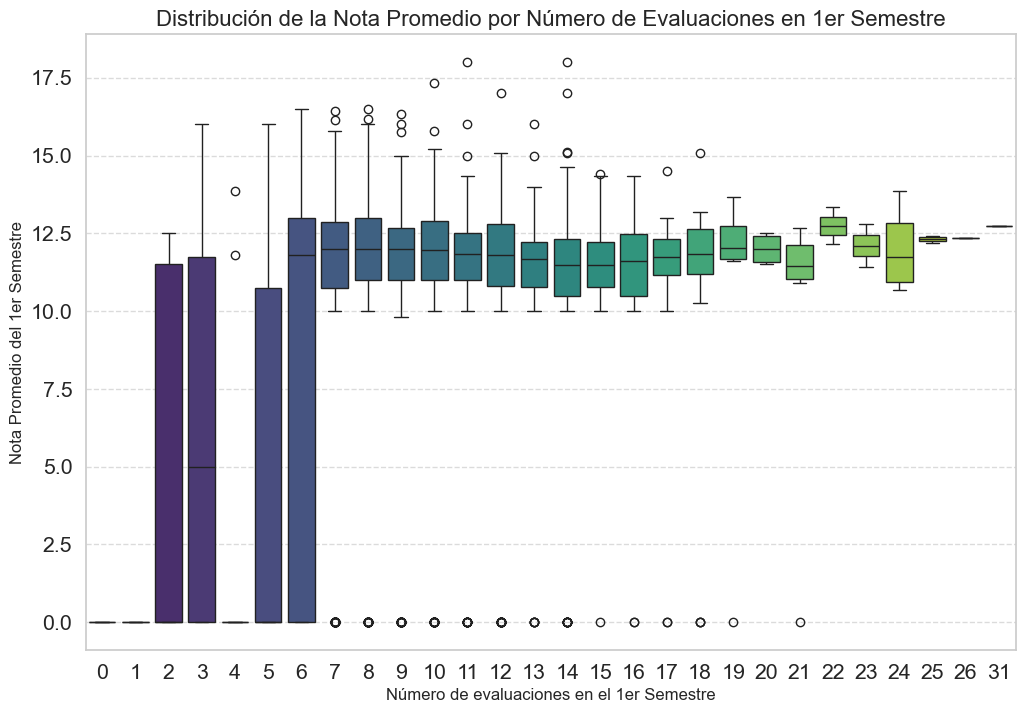

In [40]:
plt.figure(figsize=(12, 8))

# INVERTIMOS LAS VARIABLES EN LOS EJES X e Y
sns.boxplot(
    data=df,
    x='Curricular units 1st sem (evaluations)', # Variable discreta como categoría
    y='first_semester_grade',                # Variable continua para la distribución
    palette='viridis'
)

plt.title('Distribución de la Nota Promedio por Número de Evaluaciones en 1er Semestre', fontsize=16)
plt.xlabel('Número de evaluaciones en el 1er Semestre', fontsize=12)
plt.ylabel('Nota Promedio del 1er Semestre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Los estudiantes con 5 o menos evaluaciones tienen un rendimiento bajo y muy variable. A partir de 6 evaluaciones, la nota promedio salta a un nivel consistentemente más alto (entre 10 y 13). La presencia de numerosos outliers con nota cero para este último grupo sugiere fuertemente que el valor '0' no es una calificación real, sino un código para abandono.

### Unidades curriculares 2do semestre (Matriculados)
'Curricular units 2nd sem (Enrolled)'

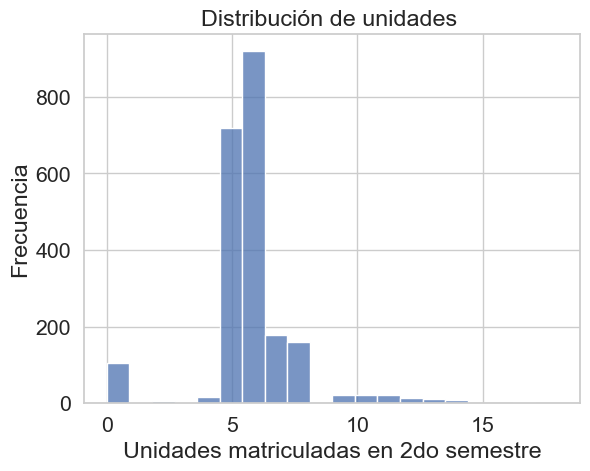

In [41]:
sns.histplot(df['Curricular units 2nd sem (enrolled)'], bins=20)
plt.xlabel('Unidades matriculadas en 2do semestre')
plt.ylabel('Frecuencia')
plt.title('Distribución de unidades ')
plt.show()

La carga académica del segundo semestre es muy homogénea, con una fuerte concentración de estudiantes matriculados en 6 unidades. La distribución está levemente sesgada a la derecha, mostrando que es muy raro que un estudiante se matricule en más de 8 unidades. El pequeño pico en 0 sugiere un grupo de estudiantes que no se reinscribió.

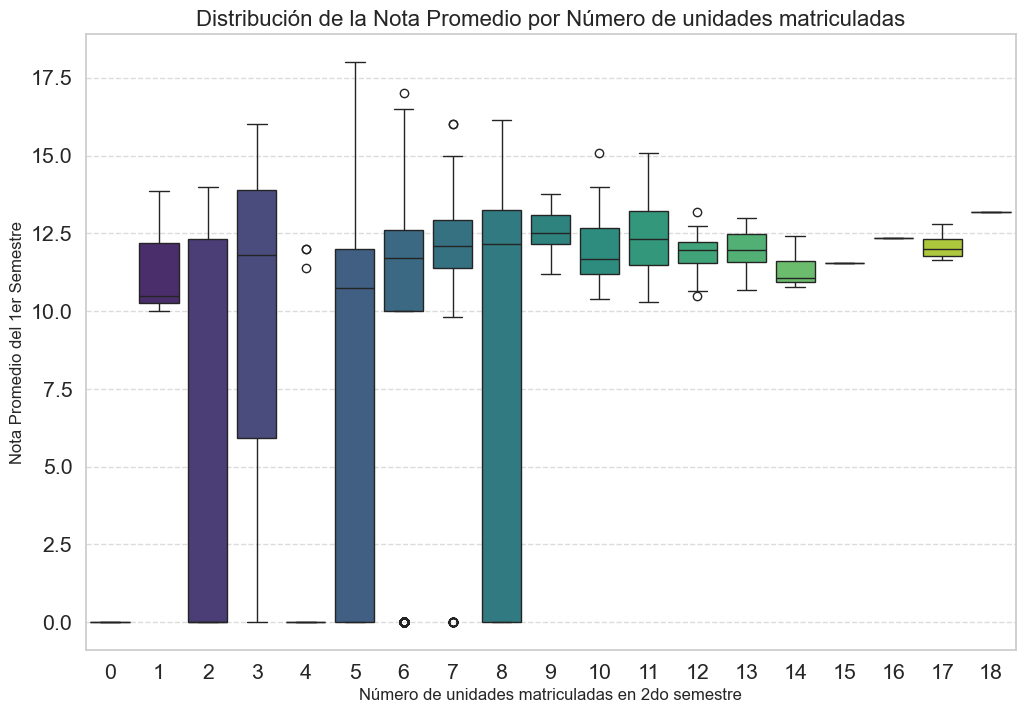

In [42]:
plt.figure(figsize=(12, 8))

# INVERTIMOS LAS VARIABLES EN LOS EJES X e Y
sns.boxplot(
    data=df,
    x='Curricular units 2nd sem (enrolled)', # Variable discreta como categoría
    y='first_semester_grade',                # Variable continua para la distribución
    palette='viridis'
)

plt.title('Distribución de la Nota Promedio por Número de unidades matriculadas', fontsize=16)
plt.xlabel('Número de unidades matriculadas en 2do semestre', fontsize=12)
plt.ylabel('Nota Promedio del 1er Semestre', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El gráfico muestra que los estudiantes que se matriculan en una carga académica estándar (5 o más unidades) en el segundo semestre tuvieron, en general, un buen y consistente rendimiento en el primero. En contraste, aquellos que se matriculan en muy pocas unidades (1-4) presentan una variabilidad de notas extremadamente alta.

# **Preprocesamiento**


## Division de datos

Dividimos los datos 30% test y 70% entrenamiento y proporcionamos el parametro __random_state = 42__ para replicabilidad

In [43]:
X= df
Y_Estado=df['Estado']
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_Estado, X_test_Estado, Y_train_Estado, Y_test_Estado = train_test_split(X, Y_Estado, test_size=0.3, random_state=42)
print("Clasificación - Estado:")
print("Train:", X_train_Estado.shape, "Test:", X_test_Estado.shape)

Clasificación - Estado:
Train: (1550, 39) Test: (665, 39)


Aqui podemos ver el tamaño de las muestras tanto de entreo como de prueba

# **KNN Classifier**

In [44]:
K_values= range(1,21)
puntaje_entreno_Estado=[]
puntaje_prueba_Estado=[]
for k in K_values:
    KNclas_model=KNeighborsClassifier(n_neighbors=k)
    KNclas_model.fit(X_train_Estado,Y_train_Estado)
    puntaje_entreno_Estado.append(KNclas_model.score(X_train_Estado, Y_train_Estado))
    puntaje_prueba_Estado.append(KNclas_model.score(X_test_Estado, Y_test_Estado))
    

Para el modelo deee **Clasificación** decidimos usar la metrica de **Accuracy** debido aque la variable respuesta __Estado__ presenta un desbalance en sus clases

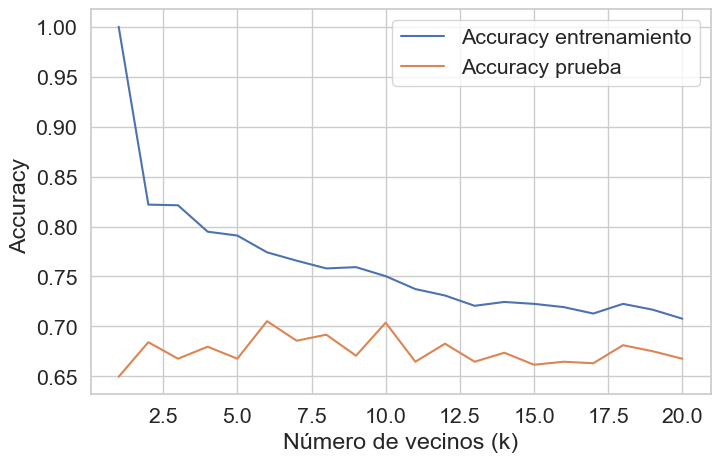

In [45]:

plt.figure(figsize=(8,5))
plt.plot(K_values, puntaje_entreno_Estado, label="Accuracy entrenamiento")
plt.plot(K_values, puntaje_prueba_Estado, label="Accuracy prueba")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy ")
plt.legend()
plt.show()

Luego de calcular el __Balanced Acurracy score__ para distintos valores de k tomamos el mejor puntaje del teste y nos quedamos con el K que lo obtuvo.
Para este caso decidimos usar además la metrica **f1_score** con el parametro **average='macro'** debido a que consideramos que por el desbalance entre clases que presenta la variable lo mejor seria darle el mismo valor a todas las clases.
Además de generar una matriz de confusión, calcular el ROC (para cada clase) y  el AUC de manera que tengamos una vista más completa del desempeño del modelo.

Mejor k: 6
F1-score (macro): 0.5025380710659898


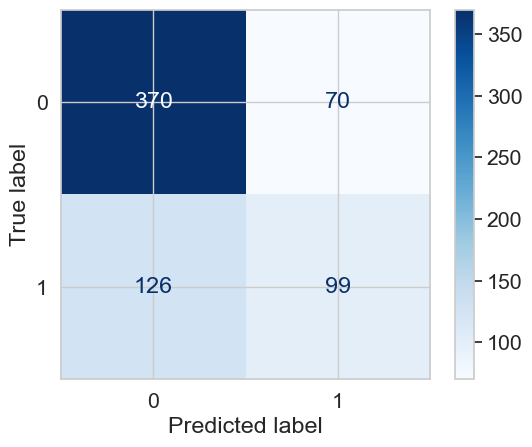

ROC AUC: 0.71


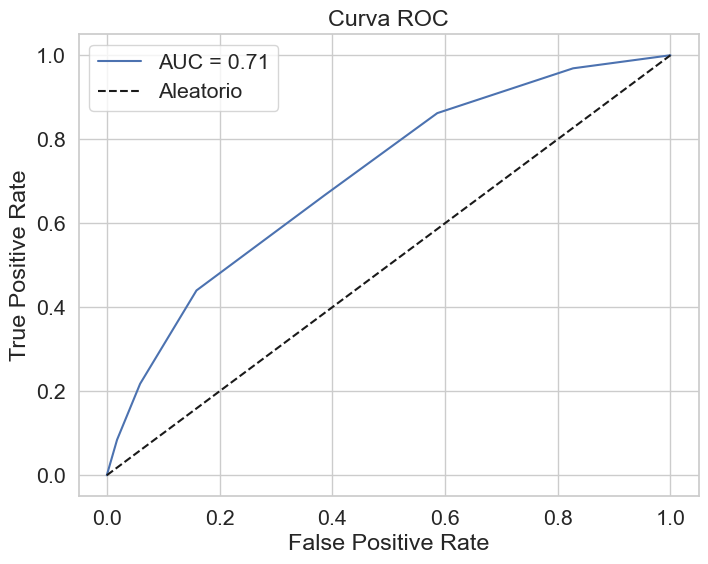

In [46]:
best_k = K_values[puntaje_prueba_Estado.index(max(puntaje_prueba_Estado))]
print(f"Mejor k: {best_k}")

KNclas_model = KNeighborsClassifier(n_neighbors=best_k)
KNclas_model.fit(X_train_Estado, Y_train_Estado)
y_pred = KNclas_model.predict(X_test_Estado)

# Métricas
print("F1-score (macro):", f1_score(Y_test_Estado, y_pred))

cm = confusion_matrix(Y_test_Estado, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

y_score = KNclas_model.predict_proba(X_test_Estado)[:, 1]  # Probabilidades


roc_auc = roc_auc_score(Y_test_Estado, y_score)
print(f"ROC AUC: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(Y_test_Estado, y_score)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

# **KNN Regresion**

## Preparar datos

In [47]:
# 1. Definir la lista de columnas a excluir para evitar data leakage
features_to_exclude = [
    'overall_grade_avg',
    'first_semester_grade',
    'second_semester_grade',
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (approved)',
    'grade_change',                          
    'Estado'                                  
]

# 2. Separar características (X) y variable objetivo (y)
X = df.drop(columns=features_to_exclude)
y = df['overall_grade_avg']

X['is_inactive'] = (X['Curricular units 1st sem (evaluations)'] == 0).astype(int)
# 3. Identificar columnas categóricas y numéricas, ya se hizo arriba pero xd.
categorical_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance\t', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International'
]

numerical_features = [
    'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP', 'is_inactive'
]

# Asegurémonos de que todas las columnas de X están en una de las dos listas
assert len(categorical_features) + len(numerical_features) == X.shape[1]

print("Características seleccionadas para el modelo.")
print(f"Número de características categóricas: {len(categorical_features)}")
print(f"Número de características numéricas: {len(numerical_features)}")

Características seleccionadas para el modelo.
Número de características categóricas: 18
Número de características numéricas: 15



Dimensiones de X_train procesado: (1772, 224)
Dimensiones de X_test procesado: (443, 224)

Iniciando la búsqueda del valor óptimo de k...


Búsqueda de k completada.


El valor óptimo de k es: 24


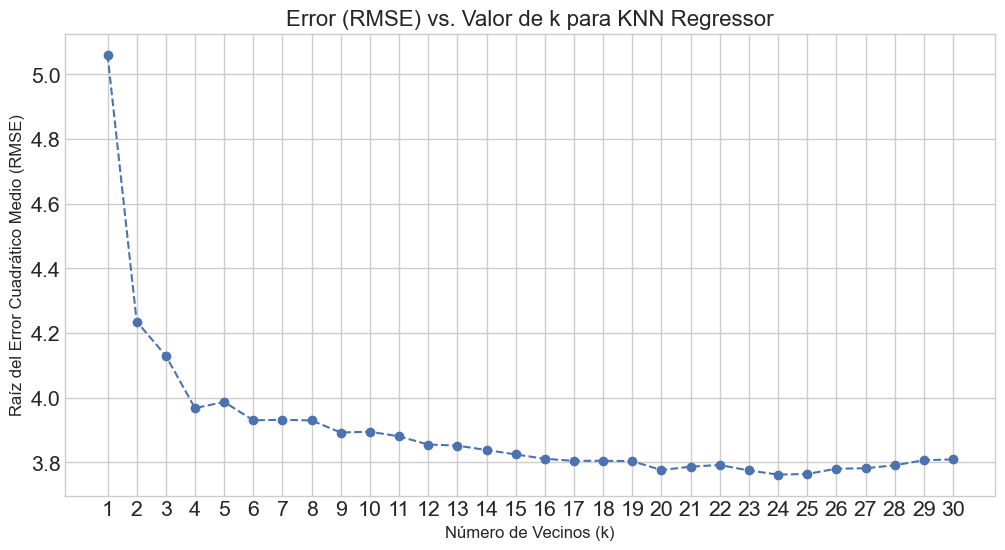

In [48]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Crear el preprocesador
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False para facilitar la inspección

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Por si alguna columna no fue clasificada
)

# Aplicar el preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nDimensiones de X_train procesado: {X_train_processed.shape}")
print(f"Dimensiones de X_test procesado: {X_test_processed.shape}")


# --- Búsqueda del mejor valor de k ---
k_range = range(1, 31)
rmse_scores = []

print("\nIniciando la búsqueda del valor óptimo de k...")
for k in k_range:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_processed, y_train)
    y_pred = knn_regressor.predict(X_test_processed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print("Búsqueda de k completada.")

# Guardar el k óptimo en una variable
optimal_k = k_range[np.argmin(rmse_scores)]
print(f"El valor óptimo de k es: {optimal_k}")

# --- Visualización para la selección de k ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.plot(k_range, rmse_scores, marker='o', linestyle='--')
plt.title('Error (RMSE) vs. Valor de k para KNN Regressor', fontsize=16)
plt.xlabel('Número de Vecinos (k)', fontsize=12)
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()



--- Evaluación del Modelo KNN Final (k=24) ---
Error Absoluto Medio (MAE): 2.6039
Raíz del Error Cuadrático Medio (RMSE): 3.7620
Coeficiente de Determinación (R²): 0.5176


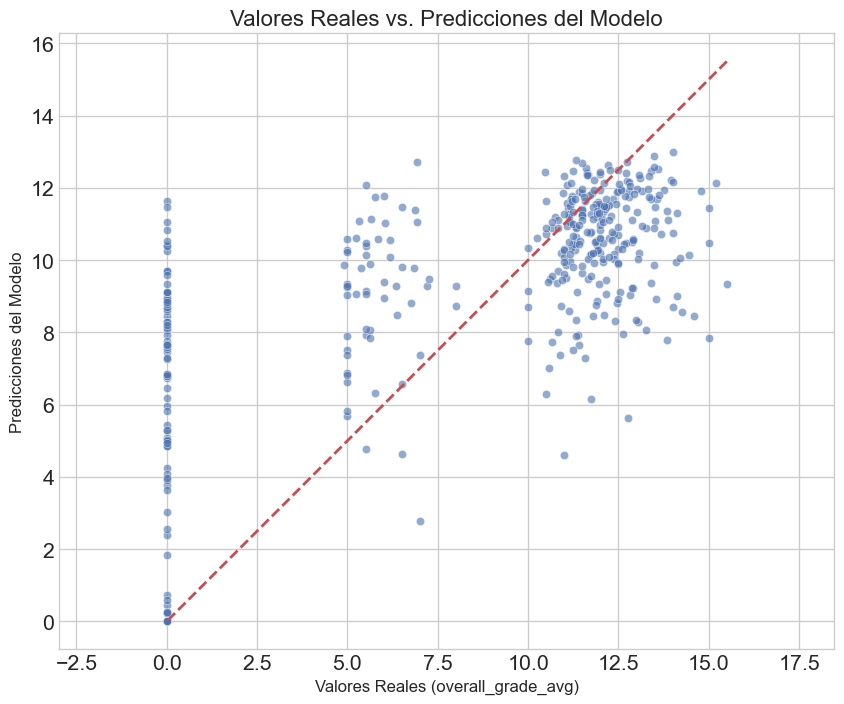

In [49]:
optimal_k = 24

# Crear y entrenar el modelo final
best_knn_model = KNeighborsRegressor(n_neighbors=optimal_k)
best_knn_model.fit(X_train_processed, y_train)

# Realizar predicciones finales
y_pred_final = best_knn_model.predict(X_test_processed)

# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)

# Mostrar los resultados
print(f"\n--- Evaluación del Modelo KNN Final (k={optimal_k}) ---")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# --- Análisis Gráfico ---

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)
p1 = max(max(y_pred_final), max(y_test))
p2 = min(min(y_pred_final), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=2)
plt.title('Valores Reales vs. Predicciones del Modelo', fontsize=16)
plt.xlabel('Valores Reales (overall_grade_avg)', fontsize=12)
plt.ylabel('Predicciones del Modelo', fontsize=12)
plt.axis('equal')
plt.show()

El modelo KNN implementado, aunque sencillo, ha demostrado ser una herramienta válida para la predicción del rendimiento académico, logrando explicar una porción sustancial de la variabilidad en las notas. Los resultados sugieren que el modelo es robusto para predecir casos generales, pero su rendimiento disminuye frente a estudiantes con perfiles atípicos, lo que abre la puerta a futuras mejoras.

Hemos tenido dificultades en hacer que tenga en cuenta que la variable de Curricular units 1st sem (without evaluations).

## **Conclusiones**

El modelo de clasifiación pierde mucho al tratarse de una variable muy desbalanceada, ademas el gran número de vecinos dificultó la correcta clasificación.